In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from numpy import sqrt

from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
import optuna

C:\Users\user\AppData\Roaming\Python\Python314\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:

df = pd.read_csv("../Dataset/nasa_power_prepared_data.csv")
df = df.sort_values("date")


In [5]:
SELECTED_FEATURES_FROM_LGBM = [
    'month_progress', 'dayofyear', 'doy_sin', 'tsoil4_roll7_std', 'gwettop_roll7_std', 
    'tsoil3_roll7_std', 't2m_trend_strength', 'ts_max_roll7_std', 'to3', 'rhoa_roll7_std', 
    'rhoa_roll3_std', 'tsoil4_lag7', 'gwettop_roll3_std', 'doy_cos', 'tsoil4_roll3_std', 
    'ts_min_roll7_std', 't10m_min_roll7_std', 'tsoil4', 'to3_lag7', 't10m_max_roll7_std', 
    'gwetprof_roll7_std', 'to3_lag3', 'to3_lag5', 'v2m_roll7_std', 't2m_anomaly_lag3', 
    't2m_rolling_iqr', 'v50m_roll7_std', 'tsoil2_roll7_std', 't2mwet_roll7_std', 
    't2m_anomaly', 'gwetroot_roll7_std', 'to3_lag4', 'to3_lag6', 'tsoil3_lag7', 
    'ts_min_roll3_std', 'to3_lag1', 't2m_min_roll7_std', 't2m_max_roll7_std', 
    't2m_anomaly_lag2', 'v2m_roll7_mean', 'temp_gradient_surface_lag3', 
    'temp_gradient_surface_lag1', 't2m_volatility_3d_lag1', 'temp_gradient_altitude', 
    't10m_roll7_std', 'tsoil2_roll3_std', 'ts_roll7_std', 'soil_temp_gradient_deep', 
    'soil_temp_moisture', 'temp_gradient_surface', 'gwetroot_roll3_std', 
    'gwetprof_roll3_std', 'ts_max_roll3_std', 't10m_min_roll3_std', 'to3_lag2', 
    't2m_rolling_p75', 'v50m_roll3_std', 'soil_temp_gradient_shallow', 't2m_roll7_std', 
    't2mwet_roll3_std', 't2m_daily_change', 'tsoil3_roll3_std', 'v10m_roll7_std', 
    'v2m_roll3_std', 'tsoil3', 't2m_volatility_3d_lag2', 't2m_momentum_7d', 
    'evptrns_lag7', 'week_cos', 't2m_daily_change_lag2', 't2m_rolling_p25', 
    'ts_max_roll7_mean', 't2m_position_in_week', 't2m_anomaly_lag1', 'tsurf_roll7_std', 
    't2mwet_roll7_mean', 'v50m_roll7_mean', 't2m_relative_to_recent_min', 
    't2m_max_roll3_std', 'tsoil4_lag5', 'gwettop_lag7', 't10m_range', 
    't10m_max_roll3_std', 'ts_range_lag3', 't2m_volatility_3d_lag3', 't10m_max_roll7_mean',
    'tsoil1_roll3_std', 'week_sin', 'tsoil4_lag6', 't2mwet_lag7', 't2m_min_roll3_std', 
    'tsoil1_roll7_std', 'tsoil3_lag6', 'rhoa_roll7_mean', 'gwettop_roll7_mean', 
    't10m_max_lag7', 'v10m_roll3_std', 'tsoil2_roll7_mean', 'evptrns_lag3', 
    'evptrns_lag6', 'temp_gradient_soil', 'ts_min_roll7_mean', 't2m_momentum_3d', 
    't10m_range_lag7', 't2m_daily_change_lag3', 't2m_daily_change_lag1', 't2mwet', 
    'v2m_lag4', 'ts_range_lag7', 'ts_max', 'v50m_lag7', 'ts_range', 'ts', 'v50m_lag5',
    'et_total_lag7', 't10m_range_lag5', 't2m_volatility_7d', 'v10m_roll7_mean', 
    'tsoil4_lag4', 'v2m_lag6', 't10m_min_roll7_mean', 'temp_gradient_surface_lag2', 
    'evptrns_lag1', 't2mwet_lag3', 'evaporation_potential', 't2m_max_roll7_mean', 
    'tsoil2_lag7', 'ts_min_lag3', 'evland_lag7', 'et_total', 'v2m_lag7', 'evland_lag2',
    'ts_min_roll3_mean', 'v2m_lag3', 'v2m_roll3_mean', 't10m_min_lag7', 't10m_max_lag4',
    'ts_roll3_std', 'tsoil3_roll7_mean', 'v50m_lag3', 'evland_lag1', 'tsoil4_lag2', 
    'v50m_lag4', 'v2m_lag2', 't10m_roll3_std', 'v50m', 't10m_lag7', 'evland', 
    't10m_min', 'ts_min_lag1', 'ts_max_lag7', 't2m_range_lag7', 'v50m_lag6', 
    'surface_efficiency', 't2mwet_roll3_mean', 'tsoil1_lag7', 'v50m_roll3_mean', 
    't2m_range', 't10m_max', 't2mwet_lag5', 't10m_range_lag4', 'tsoil4_lag1', 
    'v2m_lag5', 't2m_roll3_std', 'ts_min_lag7', 't2m_min_roll7_mean', 't10m_max_roll3_mean',
    'ts_range_lag2', 'gwettop_roll3_mean', 'tsoil4_roll7_mean', 't2m_range_lag5', 
    't2m_max_lag5', 't2m_range_lag1', 't2m_max', 'v50m_lag2', 'evptrns_lag2', 
    't10m_max_lag5', 'tsoil2_lag5', 'ts_max_roll3_mean', 'v50m_lag1', 't10m_range_lag2',
    't2mwet_lag4', 'et_total_lag3', 't2m_max_lag7', 'tsoil4_roll3_mean', 't10m_min_lag5',
    't10m_min_roll3_mean', 'evland_lag5', 'ts_range_lag5', 'evptrns', 't2m_acceleration',
    'tsoil3_lag5', 'evland_lag6', 'evptrns_lag5', 't10m_range_lag6', 'et_total_lag1', 
    'ts_max_lag6', 'gwetprof_lag7', 'evland_lag4', 't10m_min_lag6'
]


In [6]:
LOOKAHEAD = 7  # Forecast 7 วันข้างหน้า
target_cols = [f"t2m_d{i}_forecast" for i in range(1, LOOKAHEAD + 1)]

# เลือกเฉพาะ features ที่มีในข้อมูล
available_features = [f for f in SELECTED_FEATURES_FROM_LGBM if f in df.columns]
print(f"\nUsing {len(available_features)} features out of {len(SELECTED_FEATURES_FROM_LGBM)} selected")

# สร้าง dataset
dataset = df[available_features + target_cols].dropna()
X = dataset[available_features]
Y = dataset[target_cols]

print(f"Final dataset shape: X={X.shape}, Y={Y.shape}")


Using 16 features out of 200 selected
Final dataset shape: X=(16389, 16), Y=(16389, 7)


In [7]:

train_size = int(len(X) * 0.1) 
X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
Y_train, Y_test = Y.iloc[:train_size], Y.iloc[train_size:]

print(f"Train size: {X_train.shape}, Test size: {X_test.shape}")

Train size: (1638, 16), Test size: (14751, 16)


In [8]:
val_ratio = 0.2
val_split_idx = int(len(X_train) * (1 - val_ratio))

X_train_opt = X_train.iloc[:val_split_idx]
Y_train_opt = Y_train.iloc[:val_split_idx]
X_val_opt   = X_train.iloc[val_split_idx:]
Y_val_opt   = Y_train.iloc[val_split_idx:]

print("Optuna train size:", X_train_opt.shape, Y_train_opt.shape)
print("Optuna val   size:", X_val_opt.shape, Y_val_opt.shape)


def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 10.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 10.0, log=True),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'objective': 'reg:squarederror',
        'random_state': 42,
        'n_jobs': -1
    }
    
    base_xgb = XGBRegressor(**params)
    model = MultiOutputRegressor(base_xgb)
    
    model.fit(X_train_opt, Y_train_opt)
    Y_pred_val = model.predict(X_val_opt)
    
    rmse_scores = []
    for i in range(LOOKAHEAD):
        rmse_i = sqrt(mean_squared_error(Y_val_opt.iloc[:, i], Y_pred_val[:, i]))
        rmse_scores.append(rmse_i)
    
    return np.mean(rmse_scores)

study = optuna.create_study(direction='minimize',
                            study_name='xgb_t2m_forecast',
                            sampler=optuna.samplers.TPESampler(seed=42))

print("\nStarting optimization... (100 trials, max 90 minutes)")
study.optimize(objective, n_trials=100, timeout=5400, show_progress_bar=True)

print("Optuna Optimization Complete")
print(f"Best RMSE: {study.best_value:.4f}")
print("Best parameters:")
for key, value in study.best_params.items():
    print(f"   {key}: {value}")

best_params = study.best_params
best_params.update({
    'objective': 'reg:squarederror',
    'random_state': 42,
    'n_jobs': -1
})

[I 2025-11-25 11:29:42,460] A new study created in memory with name: xgb_t2m_forecast


Optuna train size: (1310, 16) (1310, 7)
Optuna val   size: (328, 16) (328, 7)

Starting optimization... (100 trials, max 90 minutes)


Best trial: 0. Best value: 1.21925:   1%|          | 1/100 [00:05<08:44,  5.30s/it, 5.29/5400 seconds]

[I 2025-11-25 11:29:47,758] Trial 0 finished with value: 1.2192464425981713 and parameters: {'n_estimators': 437, 'learning_rate': 0.2536999076681772, 'max_depth': 12, 'subsample': 0.8394633936788146, 'colsample_bytree': 0.6624074561769746, 'reg_alpha': 2.5348407664333426e-07, 'reg_lambda': 3.3323645788192616e-08, 'min_child_weight': 9}. Best is trial 0 with value: 1.2192464425981713.


Best trial: 1. Best value: 1.21136:   2%|▏         | 2/100 [00:07<05:55,  3.63s/it, 7.76/5400 seconds]

[I 2025-11-25 11:29:50,225] Trial 1 finished with value: 1.2113562950043966 and parameters: {'n_estimators': 641, 'learning_rate': 0.11114989443094977, 'max_depth': 3, 'subsample': 0.9879639408647978, 'colsample_bytree': 0.9329770563201687, 'reg_alpha': 8.148018307012941e-07, 'reg_lambda': 4.329370014459266e-07, 'min_child_weight': 2}. Best is trial 1 with value: 1.2113562950043966.


Best trial: 2. Best value: 1.13124:   3%|▎         | 3/100 [00:12<06:33,  4.05s/it, 12.32/5400 seconds]

[I 2025-11-25 11:29:54,781] Trial 2 finished with value: 1.1312441564404492 and parameters: {'n_estimators': 374, 'learning_rate': 0.05958389350068958, 'max_depth': 8, 'subsample': 0.7164916560792167, 'colsample_bytree': 0.8447411578889518, 'reg_alpha': 1.8007140198129195e-07, 'reg_lambda': 4.258943089524393e-06, 'min_child_weight': 4}. Best is trial 2 with value: 1.1312441564404492.


Best trial: 2. Best value: 1.13124:   4%|▍         | 4/100 [00:15<05:51,  3.66s/it, 15.37/5400 seconds]

[I 2025-11-25 11:29:57,828] Trial 3 finished with value: 1.2084579764837216 and parameters: {'n_estimators': 510, 'learning_rate': 0.14447746112718687, 'max_depth': 5, 'subsample': 0.8056937753654446, 'colsample_bytree': 0.836965827544817, 'reg_alpha': 2.6185068507773707e-08, 'reg_lambda': 0.0029369981104377003, 'min_child_weight': 2}. Best is trial 2 with value: 1.1312441564404492.


Best trial: 2. Best value: 1.13124:   5%|▌         | 5/100 [00:18<05:31,  3.49s/it, 18.56/5400 seconds]

[I 2025-11-25 11:30:01,021] Trial 4 finished with value: 1.1883310413166353 and parameters: {'n_estimators': 158, 'learning_rate': 0.2521267904777921, 'max_depth': 15, 'subsample': 0.9233589392465844, 'colsample_bytree': 0.7218455076693483, 'reg_alpha': 7.569183361880229e-08, 'reg_lambda': 0.014391207615728067, 'min_child_weight': 5}. Best is trial 2 with value: 1.1312441564404492.


Best trial: 5. Best value: 1.09251:   6%|▌         | 6/100 [00:19<03:59,  2.54s/it, 19.27/5400 seconds]

[I 2025-11-25 11:30:01,731] Trial 5 finished with value: 1.0925083933534308 and parameters: {'n_estimators': 209, 'learning_rate': 0.05388108577817234, 'max_depth': 3, 'subsample': 0.9637281608315128, 'colsample_bytree': 0.7035119926400067, 'reg_alpha': 0.009176996354542699, 'reg_lambda': 6.388511557344611e-06, 'min_child_weight': 6}. Best is trial 5 with value: 1.0925083933534308.


Best trial: 5. Best value: 1.09251:   7%|▋         | 7/100 [00:30<08:07,  5.25s/it, 30.08/5400 seconds]

[I 2025-11-25 11:30:12,543] Trial 6 finished with value: 1.1893245633223515 and parameters: {'n_estimators': 592, 'learning_rate': 0.01875220945578641, 'max_depth': 15, 'subsample': 0.9100531293444458, 'colsample_bytree': 0.9757995766256756, 'reg_alpha': 1.1309571585271483, 'reg_lambda': 0.002404915432737351, 'min_child_weight': 10}. Best is trial 5 with value: 1.0925083933534308.


Best trial: 7. Best value: 1.01148:   8%|▊         | 8/100 [00:30<05:47,  3.77s/it, 30.70/5400 seconds]

[I 2025-11-25 11:30:13,162] Trial 7 finished with value: 1.0114820653450443 and parameters: {'n_estimators': 179, 'learning_rate': 0.01947558230629543, 'max_depth': 3, 'subsample': 0.7301321323053057, 'colsample_bytree': 0.7554709158757928, 'reg_alpha': 2.7678419414850017e-06, 'reg_lambda': 0.28749982347407854, 'min_child_weight': 4}. Best is trial 7 with value: 1.0114820653450443.


Best trial: 7. Best value: 1.01148:   9%|▉         | 9/100 [00:32<04:38,  3.06s/it, 32.18/5400 seconds]

[I 2025-11-25 11:30:14,641] Trial 8 finished with value: 1.1271942923854597 and parameters: {'n_estimators': 353, 'learning_rate': 0.06333268775321843, 'max_depth': 4, 'subsample': 0.9208787923016158, 'colsample_bytree': 0.6298202574719083, 'reg_alpha': 7.620481786158549, 'reg_lambda': 0.08916674715636537, 'min_child_weight': 2}. Best is trial 7 with value: 1.0114820653450443.


Best trial: 7. Best value: 1.01148:  10%|█         | 10/100 [00:35<04:47,  3.20s/it, 35.70/5400 seconds]

[I 2025-11-25 11:30:18,162] Trial 9 finished with value: 1.1864708463949203 and parameters: {'n_estimators': 104, 'learning_rate': 0.1601531217136121, 'max_depth': 12, 'subsample': 0.8916028672163949, 'colsample_bytree': 0.9085081386743783, 'reg_alpha': 4.638759594322625e-08, 'reg_lambda': 1.683416412018213e-05, 'min_child_weight': 2}. Best is trial 7 with value: 1.0114820653450443.


Best trial: 7. Best value: 1.01148:  11%|█         | 11/100 [00:43<06:39,  4.49s/it, 43.10/5400 seconds]

[I 2025-11-25 11:30:25,562] Trial 10 finished with value: 1.1599584955057531 and parameters: {'n_estimators': 951, 'learning_rate': 0.010206070557577008, 'max_depth': 7, 'subsample': 0.6071847502459279, 'colsample_bytree': 0.768161603273759, 'reg_alpha': 2.6462851656372712e-05, 'reg_lambda': 5.475583883351951, 'min_child_weight': 7}. Best is trial 7 with value: 1.0114820653450443.


Best trial: 7. Best value: 1.01148:  12%|█▏        | 12/100 [00:44<05:21,  3.66s/it, 44.86/5400 seconds]

[I 2025-11-25 11:30:27,328] Trial 11 finished with value: 1.1236890823676295 and parameters: {'n_estimators': 262, 'learning_rate': 0.028310060673998678, 'max_depth': 6, 'subsample': 0.7184348852751731, 'colsample_bytree': 0.7143417233780396, 'reg_alpha': 0.014762390709189041, 'reg_lambda': 7.476931580627821e-05, 'min_child_weight': 7}. Best is trial 7 with value: 1.0114820653450443.


Best trial: 7. Best value: 1.01148:  13%|█▎        | 13/100 [00:45<04:05,  2.82s/it, 45.76/5400 seconds]

[I 2025-11-25 11:30:28,220] Trial 12 finished with value: 1.031111679585701 and parameters: {'n_estimators': 244, 'learning_rate': 0.030844277238946734, 'max_depth': 3, 'subsample': 0.6857486542395244, 'colsample_bytree': 0.7670719489688085, 'reg_alpha': 0.0005623543219870731, 'reg_lambda': 8.876711193233222, 'min_child_weight': 4}. Best is trial 7 with value: 1.0114820653450443.


Best trial: 7. Best value: 1.01148:  14%|█▍        | 14/100 [00:55<06:51,  4.79s/it, 55.09/5400 seconds]

[I 2025-11-25 11:30:37,557] Trial 13 finished with value: 1.1901327869962448 and parameters: {'n_estimators': 731, 'learning_rate': 0.02629964587089841, 'max_depth': 9, 'subsample': 0.6908556046603515, 'colsample_bytree': 0.8056891692692755, 'reg_alpha': 4.8943117959615636e-05, 'reg_lambda': 9.868745464853728, 'min_child_weight': 4}. Best is trial 7 with value: 1.0114820653450443.


Best trial: 7. Best value: 1.01148:  15%|█▌        | 15/100 [00:56<05:30,  3.88s/it, 56.88/5400 seconds]

[I 2025-11-25 11:30:39,343] Trial 14 finished with value: 1.0746205645478313 and parameters: {'n_estimators': 302, 'learning_rate': 0.014156294598725541, 'max_depth': 5, 'subsample': 0.6480289297988233, 'colsample_bytree': 0.7688977176118464, 'reg_alpha': 6.410685361426296e-06, 'reg_lambda': 0.3348237203296227, 'min_child_weight': 4}. Best is trial 7 with value: 1.0114820653450443.


Best trial: 7. Best value: 1.01148:  16%|█▌        | 16/100 [01:00<05:31,  3.95s/it, 60.98/5400 seconds]

[I 2025-11-25 11:30:43,447] Trial 15 finished with value: 1.1616336643534684 and parameters: {'n_estimators': 219, 'learning_rate': 0.03078105461592632, 'max_depth': 10, 'subsample': 0.7599922797534859, 'colsample_bytree': 0.8637174471935178, 'reg_alpha': 0.0011136144018950372, 'reg_lambda': 0.7073220474194049, 'min_child_weight': 5}. Best is trial 7 with value: 1.0114820653450443.


Best trial: 7. Best value: 1.01148:  17%|█▋        | 17/100 [01:01<03:59,  2.88s/it, 61.38/5400 seconds]

[I 2025-11-25 11:30:43,846] Trial 16 finished with value: 1.0331433558516987 and parameters: {'n_estimators': 109, 'learning_rate': 0.039879735484396925, 'max_depth': 3, 'subsample': 0.7727119872107906, 'colsample_bytree': 0.6062041527976909, 'reg_alpha': 0.0005409471822996628, 'reg_lambda': 0.06013712167694382, 'min_child_weight': 1}. Best is trial 7 with value: 1.0114820653450443.


Best trial: 7. Best value: 1.01148:  18%|█▊        | 18/100 [01:07<05:08,  3.76s/it, 67.20/5400 seconds]

[I 2025-11-25 11:30:49,658] Trial 17 finished with value: 1.1485962256384976 and parameters: {'n_estimators': 795, 'learning_rate': 0.017029949879386743, 'max_depth': 6, 'subsample': 0.6662226394413817, 'colsample_bytree': 0.7673758708920512, 'reg_alpha': 3.409795523021247e-06, 'reg_lambda': 1.2645427938537928, 'min_child_weight': 3}. Best is trial 7 with value: 1.0114820653450443.


Best trial: 7. Best value: 1.01148:  19%|█▉        | 19/100 [01:09<04:36,  3.41s/it, 69.79/5400 seconds]

[I 2025-11-25 11:30:52,254] Trial 18 finished with value: 1.077331789894392 and parameters: {'n_estimators': 449, 'learning_rate': 0.010839293998112624, 'max_depth': 5, 'subsample': 0.6051592734557237, 'colsample_bytree': 0.6879583627725717, 'reg_alpha': 0.007645159361342282, 'reg_lambda': 0.0014561469589187425, 'min_child_weight': 7}. Best is trial 7 with value: 1.0114820653450443.


Best trial: 7. Best value: 1.01148:  20%|██        | 20/100 [01:14<05:10,  3.88s/it, 74.76/5400 seconds]

[I 2025-11-25 11:30:57,218] Trial 19 finished with value: 1.1426956987932366 and parameters: {'n_estimators': 320, 'learning_rate': 0.019880480424467592, 'max_depth': 11, 'subsample': 0.7426815878832284, 'colsample_bytree': 0.7367466368606105, 'reg_alpha': 0.24368569835445372, 'reg_lambda': 0.03387557668886888, 'min_child_weight': 6}. Best is trial 7 with value: 1.0114820653450443.


Best trial: 7. Best value: 1.01148:  21%|██        | 21/100 [01:17<04:31,  3.44s/it, 77.17/5400 seconds]

[I 2025-11-25 11:30:59,630] Trial 20 finished with value: 1.142844566016716 and parameters: {'n_estimators': 199, 'learning_rate': 0.03952419420259876, 'max_depth': 7, 'subsample': 0.8295725848486349, 'colsample_bytree': 0.814572730659528, 'reg_alpha': 7.579593232298359e-05, 'reg_lambda': 1.9702790110463648, 'min_child_weight': 3}. Best is trial 7 with value: 1.0114820653450443.


Best trial: 7. Best value: 1.01148:  22%|██▏       | 22/100 [01:17<03:18,  2.55s/it, 77.63/5400 seconds]

[I 2025-11-25 11:31:00,095] Trial 21 finished with value: 1.025327636203551 and parameters: {'n_estimators': 114, 'learning_rate': 0.040179524619117696, 'max_depth': 3, 'subsample': 0.7721868286695308, 'colsample_bytree': 0.6114327643981047, 'reg_alpha': 0.0006307748621479974, 'reg_lambda': 0.1780618755685364, 'min_child_weight': 3}. Best is trial 7 with value: 1.0114820653450443.


Best trial: 7. Best value: 1.01148:  23%|██▎       | 23/100 [01:18<02:34,  2.00s/it, 78.37/5400 seconds]

[I 2025-11-25 11:31:00,828] Trial 22 finished with value: 1.0962177993876816 and parameters: {'n_estimators': 161, 'learning_rate': 0.04120971297317577, 'max_depth': 4, 'subsample': 0.6569310443286644, 'colsample_bytree': 0.6653364163479973, 'reg_alpha': 0.0019087310365755734, 'reg_lambda': 0.2344948044673312, 'min_child_weight': 3}. Best is trial 7 with value: 1.0114820653450443.


Best trial: 7. Best value: 1.01148:  24%|██▍       | 24/100 [01:19<02:11,  1.74s/it, 79.48/5400 seconds]

[I 2025-11-25 11:31:01,946] Trial 23 finished with value: 1.1517404656223331 and parameters: {'n_estimators': 263, 'learning_rate': 0.0789172540690785, 'max_depth': 4, 'subsample': 0.7879259337101081, 'colsample_bytree': 0.8800028958848756, 'reg_alpha': 0.00017205935945262434, 'reg_lambda': 0.012402938716508655, 'min_child_weight': 4}. Best is trial 7 with value: 1.0114820653450443.


Best trial: 7. Best value: 1.01148:  25%|██▌       | 25/100 [01:21<02:06,  1.69s/it, 81.06/5400 seconds]

[I 2025-11-25 11:31:03,526] Trial 24 finished with value: 1.0595927590855152 and parameters: {'n_estimators': 401, 'learning_rate': 0.023358447944319235, 'max_depth': 3, 'subsample': 0.724251525930935, 'colsample_bytree': 0.6470229635941365, 'reg_alpha': 6.146015809123168e-06, 'reg_lambda': 3.930154478947318, 'min_child_weight': 1}. Best is trial 7 with value: 1.0114820653450443.


Best trial: 25. Best value: 0.961752:  26%|██▌       | 26/100 [01:22<01:54,  1.55s/it, 82.29/5400 seconds]

[I 2025-11-25 11:31:04,756] Trial 25 finished with value: 0.9617522376758819 and parameters: {'n_estimators': 116, 'learning_rate': 0.01402334787698392, 'max_depth': 6, 'subsample': 0.6923770747643614, 'colsample_bytree': 0.6057575681173106, 'reg_alpha': 0.06169789557749389, 'reg_lambda': 0.00028924037563814024, 'min_child_weight': 5}. Best is trial 25 with value: 0.9617522376758819.


Best trial: 25. Best value: 0.961752:  27%|██▋       | 27/100 [01:23<01:43,  1.42s/it, 83.42/5400 seconds]

[I 2025-11-25 11:31:05,883] Trial 26 finished with value: 0.963767831438109 and parameters: {'n_estimators': 111, 'learning_rate': 0.013935759781197004, 'max_depth': 6, 'subsample': 0.8569070493304349, 'colsample_bytree': 0.6041838247018737, 'reg_alpha': 0.06776674903228322, 'reg_lambda': 0.0002500138126636252, 'min_child_weight': 5}. Best is trial 25 with value: 0.9617522376758819.


Best trial: 25. Best value: 0.961752:  28%|██▊       | 28/100 [01:25<02:00,  1.67s/it, 85.67/5400 seconds]

[I 2025-11-25 11:31:08,132] Trial 27 finished with value: 1.0192017524314259 and parameters: {'n_estimators': 157, 'learning_rate': 0.01457111081383188, 'max_depth': 8, 'subsample': 0.867052079332857, 'colsample_bytree': 0.6002741599638951, 'reg_alpha': 0.07850821031886417, 'reg_lambda': 0.00035684201597370625, 'min_child_weight': 8}. Best is trial 25 with value: 0.9617522376758819.


Best trial: 25. Best value: 0.961752:  29%|██▉       | 29/100 [01:28<02:22,  2.01s/it, 88.48/5400 seconds]

[I 2025-11-25 11:31:10,944] Trial 28 finished with value: 1.0850818795559163 and parameters: {'n_estimators': 293, 'learning_rate': 0.013415691934697419, 'max_depth': 6, 'subsample': 0.8120713355300742, 'colsample_bytree': 0.6797694995179049, 'reg_alpha': 0.08786529899271978, 'reg_lambda': 0.0001604799489694701, 'min_child_weight': 5}. Best is trial 25 with value: 0.9617522376758819.


Best trial: 25. Best value: 0.961752:  30%|███       | 30/100 [01:33<03:24,  2.93s/it, 93.54/5400 seconds]

[I 2025-11-25 11:31:16,002] Trial 29 finished with value: 1.1294594410177712 and parameters: {'n_estimators': 477, 'learning_rate': 0.011922018058814092, 'max_depth': 7, 'subsample': 0.8385347428518641, 'colsample_bytree': 0.6477639824328912, 'reg_alpha': 2.6602405550644357, 'reg_lambda': 3.0439381964747143e-07, 'min_child_weight': 6}. Best is trial 25 with value: 0.9617522376758819.


Best trial: 25. Best value: 0.961752:  31%|███       | 31/100 [01:43<05:39,  4.92s/it, 103.12/5400 seconds]

[I 2025-11-25 11:31:25,581] Trial 30 finished with value: 1.1614989869892998 and parameters: {'n_estimators': 956, 'learning_rate': 0.01670678730386059, 'max_depth': 8, 'subsample': 0.6327032205834978, 'colsample_bytree': 0.6284789864183115, 'reg_alpha': 0.17967621766535138, 'reg_lambda': 0.000627124967452046, 'min_child_weight': 8}. Best is trial 25 with value: 0.9617522376758819.


Best trial: 25. Best value: 0.961752:  32%|███▏      | 32/100 [01:45<04:52,  4.31s/it, 105.99/5400 seconds]

[I 2025-11-25 11:31:28,451] Trial 31 finished with value: 1.030108703473595 and parameters: {'n_estimators': 175, 'learning_rate': 0.014506120308915916, 'max_depth': 9, 'subsample': 0.8723806260540359, 'colsample_bytree': 0.6024887583670937, 'reg_alpha': 0.03787028778321368, 'reg_lambda': 5.683884046204637e-05, 'min_child_weight': 9}. Best is trial 25 with value: 0.9617522376758819.


Best trial: 25. Best value: 0.961752:  33%|███▎      | 33/100 [01:48<04:10,  3.73s/it, 108.38/5400 seconds]

[I 2025-11-25 11:31:30,843] Trial 32 finished with value: 1.0771605522096674 and parameters: {'n_estimators': 151, 'learning_rate': 0.02053802883577644, 'max_depth': 8, 'subsample': 0.8560005597965203, 'colsample_bytree': 0.6414163151230687, 'reg_alpha': 0.5336266936847226, 'reg_lambda': 0.0004344715319699421, 'min_child_weight': 5}. Best is trial 25 with value: 0.9617522376758819.


Best trial: 25. Best value: 0.961752:  34%|███▍      | 34/100 [01:50<03:35,  3.26s/it, 110.54/5400 seconds]

[I 2025-11-25 11:31:33,002] Trial 33 finished with value: 0.9844494929449205 and parameters: {'n_estimators': 102, 'learning_rate': 0.01573775816521322, 'max_depth': 9, 'subsample': 0.8692680456473015, 'colsample_bytree': 0.678044032392604, 'reg_alpha': 0.040508770598427946, 'reg_lambda': 7.228526968042152e-07, 'min_child_weight': 8}. Best is trial 25 with value: 0.9617522376758819.


Best trial: 25. Best value: 0.961752:  35%|███▌      | 35/100 [01:53<03:20,  3.09s/it, 113.24/5400 seconds]

[I 2025-11-25 11:31:35,702] Trial 34 finished with value: 1.0372325971207756 and parameters: {'n_estimators': 108, 'learning_rate': 0.02333193212265582, 'max_depth': 12, 'subsample': 0.9573270013855837, 'colsample_bytree': 0.6735450975466386, 'reg_alpha': 0.00385385924179087, 'reg_lambda': 1.6103903885879485e-08, 'min_child_weight': 10}. Best is trial 25 with value: 0.9617522376758819.


Best trial: 25. Best value: 0.961752:  36%|███▌      | 36/100 [01:58<03:54,  3.66s/it, 118.24/5400 seconds]

[I 2025-11-25 11:31:40,698] Trial 35 finished with value: 1.054687763110082 and parameters: {'n_estimators': 209, 'learning_rate': 0.011992611301105034, 'max_depth': 10, 'subsample': 0.8162677862607134, 'colsample_bytree': 0.7405485838816213, 'reg_alpha': 1.1197657466284607e-08, 'reg_lambda': 3.206348987929344e-07, 'min_child_weight': 6}. Best is trial 25 with value: 0.9617522376758819.


Best trial: 25. Best value: 0.961752:  37%|███▋      | 37/100 [02:00<03:23,  3.23s/it, 120.44/5400 seconds]

[I 2025-11-25 11:31:42,902] Trial 36 finished with value: 1.0974920318638641 and parameters: {'n_estimators': 364, 'learning_rate': 0.016182143601192425, 'max_depth': 5, 'subsample': 0.7420030764847713, 'colsample_bytree': 0.6969179067632172, 'reg_alpha': 0.020441630019323986, 'reg_lambda': 1.5546441261238122e-06, 'min_child_weight': 8}. Best is trial 25 with value: 0.9617522376758819.


Best trial: 25. Best value: 0.961752:  38%|███▊      | 38/100 [02:08<04:58,  4.81s/it, 128.94/5400 seconds]

[I 2025-11-25 11:31:51,398] Trial 37 finished with value: 1.1592825603446795 and parameters: {'n_estimators': 552, 'learning_rate': 0.02224617947734392, 'max_depth': 9, 'subsample': 0.9390186140684275, 'colsample_bytree': 0.6611447057143601, 'reg_alpha': 0.9815512121771192, 'reg_lambda': 0.007194841557215042, 'min_child_weight': 5}. Best is trial 25 with value: 0.9617522376758819.


Best trial: 25. Best value: 0.961752:  39%|███▉      | 39/100 [02:10<03:48,  3.75s/it, 130.21/5400 seconds]

[I 2025-11-25 11:31:52,677] Trial 38 finished with value: 0.9653732113676067 and parameters: {'n_estimators': 152, 'learning_rate': 0.012897340683282577, 'max_depth': 6, 'subsample': 0.8994319221239084, 'colsample_bytree': 0.6239579393306811, 'reg_alpha': 3.9655533455788943, 'reg_lambda': 4.9774339881040035e-08, 'min_child_weight': 9}. Best is trial 25 with value: 0.9617522376758819.


Best trial: 25. Best value: 0.961752:  40%|████      | 40/100 [02:18<05:06,  5.10s/it, 138.48/5400 seconds]

[I 2025-11-25 11:32:00,942] Trial 39 finished with value: 1.1380208392326607 and parameters: {'n_estimators': 673, 'learning_rate': 0.01026328605268455, 'max_depth': 14, 'subsample': 0.8868353453760451, 'colsample_bytree': 0.6217580483886526, 'reg_alpha': 6.345287644952972, 'reg_lambda': 7.64562772318782e-08, 'min_child_weight': 9}. Best is trial 25 with value: 0.9617522376758819.


Best trial: 25. Best value: 0.961752:  41%|████      | 41/100 [02:25<05:27,  5.55s/it, 145.07/5400 seconds]

[I 2025-11-25 11:32:07,529] Trial 40 finished with value: 1.1362781267262343 and parameters: {'n_estimators': 869, 'learning_rate': 0.012386172191542047, 'max_depth': 6, 'subsample': 0.9950373995608149, 'colsample_bytree': 0.6294284908165392, 'reg_alpha': 1.8998915164284376, 'reg_lambda': 9.027490008880526e-08, 'min_child_weight': 10}. Best is trial 25 with value: 0.9617522376758819.


Best trial: 25. Best value: 0.961752:  42%|████▏     | 42/100 [02:26<04:13,  4.37s/it, 146.68/5400 seconds]

[I 2025-11-25 11:32:09,142] Trial 41 finished with value: 1.0332475028196415 and parameters: {'n_estimators': 142, 'learning_rate': 0.018121302675205675, 'max_depth': 7, 'subsample': 0.9032145994571881, 'colsample_bytree': 0.6584792933047211, 'reg_alpha': 5.238863425289327e-07, 'reg_lambda': 2.9115145335823166e-06, 'min_child_weight': 9}. Best is trial 25 with value: 0.9617522376758819.


Best trial: 25. Best value: 0.961752:  43%|████▎     | 43/100 [02:28<03:27,  3.63s/it, 148.59/5400 seconds]

[I 2025-11-25 11:32:11,056] Trial 42 finished with value: 1.073748505439919 and parameters: {'n_estimators': 234, 'learning_rate': 0.01514406735964275, 'max_depth': 5, 'subsample': 0.6936889706208227, 'colsample_bytree': 0.9924144993232912, 'reg_alpha': 0.3867587584050871, 'reg_lambda': 2.555520455980402e-05, 'min_child_weight': 7}. Best is trial 25 with value: 0.9617522376758819.


Best trial: 25. Best value: 0.961752:  44%|████▍     | 44/100 [02:34<03:53,  4.18s/it, 154.04/5400 seconds]

[I 2025-11-25 11:32:16,500] Trial 43 finished with value: 1.0516925985885388 and parameters: {'n_estimators': 190, 'learning_rate': 0.012472383586377617, 'max_depth': 13, 'subsample': 0.8545762097882101, 'colsample_bytree': 0.7262686283244757, 'reg_alpha': 0.04985811206725957, 'reg_lambda': 1.0522052184233243e-06, 'min_child_weight': 6}. Best is trial 25 with value: 0.9617522376758819.


Best trial: 25. Best value: 0.961752:  45%|████▌     | 45/100 [02:34<02:50,  3.10s/it, 154.64/5400 seconds]

[I 2025-11-25 11:32:17,104] Trial 44 finished with value: 1.1403429041162414 and parameters: {'n_estimators': 100, 'learning_rate': 0.10682789340592821, 'max_depth': 4, 'subsample': 0.9274451230613423, 'colsample_bytree': 0.704201638275901, 'reg_alpha': 0.005690501530221579, 'reg_lambda': 8.990005224370302e-06, 'min_child_weight': 9}. Best is trial 25 with value: 0.9617522376758819.


Best trial: 25. Best value: 0.961752:  46%|████▌     | 46/100 [02:36<02:29,  2.77s/it, 156.63/5400 seconds]

[I 2025-11-25 11:32:19,096] Trial 45 finished with value: 1.0790853246610472 and parameters: {'n_estimators': 256, 'learning_rate': 0.017889178164838336, 'max_depth': 6, 'subsample': 0.8940473292754174, 'colsample_bytree': 0.6215020012196998, 'reg_alpha': 9.429178604625296, 'reg_lambda': 1.3589568771552474e-08, 'min_child_weight': 4}. Best is trial 25 with value: 0.9617522376758819.


Best trial: 25. Best value: 0.961752:  47%|████▋     | 47/100 [02:39<02:29,  2.82s/it, 159.57/5400 seconds]

[I 2025-11-25 11:32:22,032] Trial 46 finished with value: 1.1269095191546439 and parameters: {'n_estimators': 149, 'learning_rate': 0.02567047115873253, 'max_depth': 10, 'subsample': 0.9694835326601756, 'colsample_bytree': 0.7895912803305587, 'reg_alpha': 0.14910746503353667, 'reg_lambda': 0.0012217998342359852, 'min_child_weight': 8}. Best is trial 25 with value: 0.9617522376758819.


Best trial: 25. Best value: 0.961752:  48%|████▊     | 48/100 [02:42<02:35,  2.99s/it, 162.94/5400 seconds]

[I 2025-11-25 11:32:25,407] Trial 47 finished with value: 1.0532232380732605 and parameters: {'n_estimators': 291, 'learning_rate': 0.010051826051030765, 'max_depth': 7, 'subsample': 0.7080477508273344, 'colsample_bytree': 0.6355040172869421, 'reg_alpha': 0.023803560352565197, 'reg_lambda': 3.785747414929348e-08, 'min_child_weight': 5}. Best is trial 25 with value: 0.9617522376758819.


Best trial: 25. Best value: 0.961752:  49%|████▉     | 49/100 [02:47<02:58,  3.51s/it, 167.67/5400 seconds]

[I 2025-11-25 11:32:30,137] Trial 48 finished with value: 1.1497867051028474 and parameters: {'n_estimators': 333, 'learning_rate': 0.18989508908101135, 'max_depth': 11, 'subsample': 0.8328945592742536, 'colsample_bytree': 0.6509081155915211, 'reg_alpha': 0.7359175706207955, 'reg_lambda': 0.003840174287572018, 'min_child_weight': 4}. Best is trial 25 with value: 0.9617522376758819.


Best trial: 25. Best value: 0.961752:  50%|█████     | 50/100 [02:48<02:17,  2.75s/it, 168.64/5400 seconds]

[I 2025-11-25 11:32:31,106] Trial 49 finished with value: 1.023523487108529 and parameters: {'n_estimators': 195, 'learning_rate': 0.019881755351474777, 'max_depth': 4, 'subsample': 0.8028482673700845, 'colsample_bytree': 0.6824654604766167, 'reg_alpha': 2.6399614470042816, 'reg_lambda': 0.00010945996646121136, 'min_child_weight': 7}. Best is trial 25 with value: 0.9617522376758819.


Best trial: 25. Best value: 0.961752:  51%|█████     | 51/100 [02:51<02:23,  2.93s/it, 172.00/5400 seconds]

[I 2025-11-25 11:32:34,458] Trial 50 finished with value: 1.1871295253346672 and parameters: {'n_estimators': 393, 'learning_rate': 0.2877083404622371, 'max_depth': 8, 'subsample': 0.8773422401921044, 'colsample_bytree': 0.7506043203606031, 'reg_alpha': 0.002995612646505541, 'reg_lambda': 2.3424123559534994e-05, 'min_child_weight': 4}. Best is trial 25 with value: 0.9617522376758819.


Best trial: 25. Best value: 0.961752:  52%|█████▏    | 52/100 [02:53<02:05,  2.62s/it, 173.89/5400 seconds]

[I 2025-11-25 11:32:36,353] Trial 51 finished with value: 0.9909949251960349 and parameters: {'n_estimators': 132, 'learning_rate': 0.014920440509459315, 'max_depth': 8, 'subsample': 0.8552362291337962, 'colsample_bytree': 0.6014049293713223, 'reg_alpha': 0.08241475778411583, 'reg_lambda': 7.062795462739661e-07, 'min_child_weight': 8}. Best is trial 25 with value: 0.9617522376758819.


Best trial: 25. Best value: 0.961752:  53%|█████▎    | 53/100 [02:56<02:02,  2.61s/it, 176.46/5400 seconds]

[I 2025-11-25 11:32:38,927] Trial 52 finished with value: 0.9827413515705198 and parameters: {'n_estimators': 136, 'learning_rate': 0.01317495454008176, 'max_depth': 9, 'subsample': 0.855297932290811, 'colsample_bytree': 0.6165244085011087, 'reg_alpha': 1.513336533308612e-07, 'reg_lambda': 7.234323791426368e-07, 'min_child_weight': 8}. Best is trial 25 with value: 0.9617522376758819.


Best trial: 25. Best value: 0.961752:  54%|█████▍    | 54/100 [02:59<02:01,  2.63s/it, 179.16/5400 seconds]

[I 2025-11-25 11:32:41,618] Trial 53 finished with value: 0.980011886159358 and parameters: {'n_estimators': 129, 'learning_rate': 0.013609344360941154, 'max_depth': 9, 'subsample': 0.8528702825405904, 'colsample_bytree': 0.6165884211187977, 'reg_alpha': 7.997910498276641e-08, 'reg_lambda': 1.3278882366160407e-07, 'min_child_weight': 8}. Best is trial 25 with value: 0.9617522376758819.


Best trial: 25. Best value: 0.961752:  55%|█████▌    | 55/100 [03:02<02:07,  2.83s/it, 182.44/5400 seconds]

[I 2025-11-25 11:32:44,901] Trial 54 finished with value: 1.04952379683073 and parameters: {'n_estimators': 215, 'learning_rate': 0.013060448243578281, 'max_depth': 9, 'subsample': 0.9123295651344001, 'colsample_bytree': 0.6177670516761916, 'reg_alpha': 1.272987244519295e-07, 'reg_lambda': 1.461278423604137e-07, 'min_child_weight': 9}. Best is trial 25 with value: 0.9617522376758819.


Best trial: 25. Best value: 0.961752:  56%|█████▌    | 56/100 [03:04<01:58,  2.70s/it, 184.83/5400 seconds]

[I 2025-11-25 11:32:47,288] Trial 55 finished with value: 0.9836020408891558 and parameters: {'n_estimators': 100, 'learning_rate': 0.011679025918286122, 'max_depth': 11, 'subsample': 0.8458474280481183, 'colsample_bytree': 0.6373644375962048, 'reg_alpha': 3.0631481534729705e-07, 'reg_lambda': 3.2300858935833724e-08, 'min_child_weight': 8}. Best is trial 25 with value: 0.9617522376758819.


Best trial: 25. Best value: 0.961752:  57%|█████▋    | 57/100 [03:08<02:02,  2.85s/it, 188.04/5400 seconds]

[I 2025-11-25 11:32:50,508] Trial 56 finished with value: 0.9879718757034149 and parameters: {'n_estimators': 175, 'learning_rate': 0.011234695241675944, 'max_depth': 11, 'subsample': 0.8235103072513801, 'colsample_bytree': 0.6375028328275534, 'reg_alpha': 3.88100509856223e-07, 'reg_lambda': 3.804816751552133e-08, 'min_child_weight': 10}. Best is trial 25 with value: 0.9617522376758819.


Best trial: 25. Best value: 0.961752:  58%|█████▊    | 58/100 [03:13<02:31,  3.62s/it, 193.44/5400 seconds]

[I 2025-11-25 11:32:55,905] Trial 57 finished with value: 1.0832949802090786 and parameters: {'n_estimators': 262, 'learning_rate': 0.01321008235071669, 'max_depth': 12, 'subsample': 0.7885446061585742, 'colsample_bytree': 0.6209614507951697, 'reg_alpha': 1.4935306879055545e-06, 'reg_lambda': 1.6171488928506548e-07, 'min_child_weight': 7}. Best is trial 25 with value: 0.9617522376758819.


Best trial: 25. Best value: 0.961752:  59%|█████▉    | 59/100 [03:16<02:21,  3.44s/it, 196.48/5400 seconds]

[I 2025-11-25 11:32:58,938] Trial 58 finished with value: 1.1661238365017308 and parameters: {'n_estimators': 135, 'learning_rate': 0.03273216273429109, 'max_depth': 10, 'subsample': 0.8451164151593389, 'colsample_bytree': 0.9501636264480458, 'reg_alpha': 6.040510192435254e-08, 'reg_lambda': 1.0924230053361634e-08, 'min_child_weight': 6}. Best is trial 25 with value: 0.9617522376758819.


Best trial: 25. Best value: 0.961752:  60%|██████    | 60/100 [03:21<02:37,  3.94s/it, 201.57/5400 seconds]

[I 2025-11-25 11:33:04,036] Trial 59 finished with value: 1.0314053614424985 and parameters: {'n_estimators': 231, 'learning_rate': 0.011019195244118353, 'max_depth': 13, 'subsample': 0.8839119669477273, 'colsample_bytree': 0.6162400103399706, 'reg_alpha': 2.4157261692724147e-08, 'reg_lambda': 2.548480998282653e-06, 'min_child_weight': 9}. Best is trial 25 with value: 0.9617522376758819.


Best trial: 25. Best value: 0.961752:  61%|██████    | 61/100 [03:24<02:17,  3.52s/it, 204.11/5400 seconds]

[I 2025-11-25 11:33:06,570] Trial 60 finished with value: 1.1542011275360498 and parameters: {'n_estimators': 131, 'learning_rate': 0.05332018147045214, 'max_depth': 11, 'subsample': 0.9050573075211501, 'colsample_bytree': 0.6637838865459074, 'reg_alpha': 1.4445952443489785e-07, 'reg_lambda': 3.132178465516862e-08, 'min_child_weight': 8}. Best is trial 25 with value: 0.9617522376758819.


Best trial: 25. Best value: 0.961752:  62%|██████▏   | 62/100 [03:25<01:53,  2.99s/it, 205.86/5400 seconds]

[I 2025-11-25 11:33:08,321] Trial 61 finished with value: 0.989301043457817 and parameters: {'n_estimators': 103, 'learning_rate': 0.016526855957429726, 'max_depth': 9, 'subsample': 0.8635193825298603, 'colsample_bytree': 0.6369057309909654, 'reg_alpha': 8.354895673562163e-07, 'reg_lambda': 8.412196211685476e-06, 'min_child_weight': 8}. Best is trial 25 with value: 0.9617522376758819.


Best trial: 25. Best value: 0.961752:  63%|██████▎   | 63/100 [03:29<01:54,  3.10s/it, 209.21/5400 seconds]

[I 2025-11-25 11:33:11,671] Trial 62 finished with value: 1.0312940232407728 and parameters: {'n_estimators': 178, 'learning_rate': 0.014067182848580993, 'max_depth': 10, 'subsample': 0.8410839568338203, 'colsample_bytree': 0.6108489947777218, 'reg_alpha': 1.132118255818993e-05, 'reg_lambda': 6.095090631068053e-07, 'min_child_weight': 8}. Best is trial 25 with value: 0.9617522376758819.


Best trial: 25. Best value: 0.961752:  64%|██████▍   | 64/100 [03:30<01:36,  2.68s/it, 210.91/5400 seconds]

[I 2025-11-25 11:33:13,371] Trial 63 finished with value: 1.0069070825531081 and parameters: {'n_estimators': 129, 'learning_rate': 0.01577420902659782, 'max_depth': 7, 'subsample': 0.9383292433734498, 'colsample_bytree': 0.6504722294241583, 'reg_alpha': 2.2556875909059756e-07, 'reg_lambda': 6.583814010377991e-08, 'min_child_weight': 7}. Best is trial 25 with value: 0.9617522376758819.


Best trial: 25. Best value: 0.961752:  65%|██████▌   | 65/100 [03:32<01:20,  2.31s/it, 212.35/5400 seconds]

[I 2025-11-25 11:33:14,809] Trial 64 finished with value: 0.9738788144357533 and parameters: {'n_estimators': 163, 'learning_rate': 0.011447424103673106, 'max_depth': 6, 'subsample': 0.8727187607759258, 'colsample_bytree': 0.6706192723497335, 'reg_alpha': 3.1663155307504734e-08, 'reg_lambda': 1.6366706936872524e-07, 'min_child_weight': 9}. Best is trial 25 with value: 0.9617522376758819.


Best trial: 25. Best value: 0.961752:  66%|██████▌   | 66/100 [03:34<01:14,  2.20s/it, 214.30/5400 seconds]

[I 2025-11-25 11:33:16,762] Trial 65 finished with value: 0.9721617549965291 and parameters: {'n_estimators': 165, 'learning_rate': 0.011487946201048753, 'max_depth': 6, 'subsample': 0.8939644440502158, 'colsample_bytree': 0.6114780858328843, 'reg_alpha': 3.378387284900273e-08, 'reg_lambda': 2.1300279193829686e-07, 'min_child_weight': 9}. Best is trial 25 with value: 0.9617522376758819.


Best trial: 25. Best value: 0.961752:  67%|██████▋   | 67/100 [03:35<01:06,  2.03s/it, 215.93/5400 seconds]

[I 2025-11-25 11:33:18,395] Trial 66 finished with value: 0.9656552432054618 and parameters: {'n_estimators': 170, 'learning_rate': 0.010195617032297023, 'max_depth': 6, 'subsample': 0.9266495024526586, 'colsample_bytree': 0.6024969113955867, 'reg_alpha': 1.7109227853630246e-08, 'reg_lambda': 1.830280562375546e-07, 'min_child_weight': 9}. Best is trial 25 with value: 0.9617522376758819.


Best trial: 25. Best value: 0.961752:  68%|██████▊   | 68/100 [03:38<01:07,  2.12s/it, 218.26/5400 seconds]

[I 2025-11-25 11:33:20,719] Trial 67 finished with value: 1.0372959351626647 and parameters: {'n_estimators': 285, 'learning_rate': 0.010758917260763957, 'max_depth': 6, 'subsample': 0.9188352988464348, 'colsample_bytree': 0.6039760804188896, 'reg_alpha': 2.3432139051244635e-08, 'reg_lambda': 2.019450926136345e-07, 'min_child_weight': 10}. Best is trial 25 with value: 0.9617522376758819.


Best trial: 25. Best value: 0.961752:  69%|██████▉   | 69/100 [03:39<00:59,  1.92s/it, 219.71/5400 seconds]

[I 2025-11-25 11:33:22,176] Trial 68 finished with value: 0.9900586445304841 and parameters: {'n_estimators': 202, 'learning_rate': 0.011484208442682125, 'max_depth': 5, 'subsample': 0.9373944165990649, 'colsample_bytree': 0.6275061653905263, 'reg_alpha': 1.277444925683695e-08, 'reg_lambda': 3.249731840456066e-07, 'min_child_weight': 9}. Best is trial 25 with value: 0.9617522376758819.


Best trial: 25. Best value: 0.961752:  70%|███████   | 70/100 [03:46<01:44,  3.48s/it, 226.82/5400 seconds]

[I 2025-11-25 11:33:29,281] Trial 69 finished with value: 1.1268804093374702 and parameters: {'n_estimators': 998, 'learning_rate': 0.010020478376507271, 'max_depth': 6, 'subsample': 0.9517115659812176, 'colsample_bytree': 0.6525851862273537, 'reg_alpha': 4.35960623218681e-08, 'reg_lambda': 1.506659378436403e-07, 'min_child_weight': 10}. Best is trial 25 with value: 0.9617522376758819.


Best trial: 25. Best value: 0.961752:  71%|███████   | 71/100 [03:47<01:20,  2.77s/it, 227.94/5400 seconds]

[I 2025-11-25 11:33:30,399] Trial 70 finished with value: 1.0254804296109572 and parameters: {'n_estimators': 166, 'learning_rate': 0.01832455466910664, 'max_depth': 5, 'subsample': 0.8934558694084445, 'colsample_bytree': 0.6105580609364545, 'reg_alpha': 8.989280366318637e-08, 'reg_lambda': 1.5926000614327876e-06, 'min_child_weight': 9}. Best is trial 25 with value: 0.9617522376758819.


Best trial: 25. Best value: 0.961752:  72%|███████▏  | 72/100 [03:50<01:14,  2.65s/it, 230.30/5400 seconds]

[I 2025-11-25 11:33:32,764] Trial 71 finished with value: 1.0544113051195092 and parameters: {'n_estimators': 231, 'learning_rate': 0.0133437243382907, 'max_depth': 7, 'subsample': 0.8996752314263321, 'colsample_bytree': 0.6015707966589592, 'reg_alpha': 4.8921457533952797e-08, 'reg_lambda': 1.0001205245548519e-07, 'min_child_weight': 9}. Best is trial 25 with value: 0.9617522376758819.


Best trial: 25. Best value: 0.961752:  73%|███████▎  | 73/100 [03:52<01:04,  2.38s/it, 232.06/5400 seconds]

[I 2025-11-25 11:33:34,518] Trial 72 finished with value: 0.9917096598114068 and parameters: {'n_estimators': 157, 'learning_rate': 0.013768562362173966, 'max_depth': 6, 'subsample': 0.8844585861001224, 'colsample_bytree': 0.6148893017574647, 'reg_alpha': 1.5901612958573102e-08, 'reg_lambda': 0.0002008626606598446, 'min_child_weight': 9}. Best is trial 25 with value: 0.9617522376758819.


Best trial: 25. Best value: 0.961752:  74%|███████▍  | 74/100 [03:53<00:56,  2.17s/it, 233.74/5400 seconds]

[I 2025-11-25 11:33:36,207] Trial 73 finished with value: 1.005747821204524 and parameters: {'n_estimators': 194, 'learning_rate': 0.012326109956245892, 'max_depth': 6, 'subsample': 0.8751827813716859, 'colsample_bytree': 0.6256517462433379, 'reg_alpha': 0.00018196513793631826, 'reg_lambda': 4.21894352558632e-07, 'min_child_weight': 10}. Best is trial 25 with value: 0.9617522376758819.


Best trial: 74. Best value: 0.949525:  75%|███████▌  | 75/100 [03:54<00:45,  1.83s/it, 234.78/5400 seconds]

[I 2025-11-25 11:33:37,239] Trial 74 finished with value: 0.9495246186953281 and parameters: {'n_estimators': 136, 'learning_rate': 0.011173575045236587, 'max_depth': 5, 'subsample': 0.9215427081297115, 'colsample_bytree': 0.6667614969782987, 'reg_alpha': 2.943775228666108e-08, 'reg_lambda': 2.1424543906102442e-08, 'min_child_weight': 9}. Best is trial 74 with value: 0.9495246186953281.


Best trial: 74. Best value: 0.949525:  76%|███████▌  | 76/100 [03:55<00:38,  1.60s/it, 235.85/5400 seconds]

[I 2025-11-25 11:33:38,313] Trial 75 finished with value: 0.9568462204171251 and parameters: {'n_estimators': 159, 'learning_rate': 0.011011259180004817, 'max_depth': 5, 'subsample': 0.979493294147986, 'colsample_bytree': 0.6693584840896539, 'reg_alpha': 8.111765087814326e-08, 'reg_lambda': 5.5273620597453565e-08, 'min_child_weight': 10}. Best is trial 74 with value: 0.9495246186953281.


Best trial: 74. Best value: 0.949525:  77%|███████▋  | 77/100 [03:57<00:34,  1.48s/it, 237.04/5400 seconds]

[I 2025-11-25 11:33:39,506] Trial 76 finished with value: 0.9599133002722232 and parameters: {'n_estimators': 170, 'learning_rate': 0.010984439423503186, 'max_depth': 5, 'subsample': 0.9690631590775295, 'colsample_bytree': 0.670202764011963, 'reg_alpha': 1.08459116961151e-08, 'reg_lambda': 4.537300214759555e-08, 'min_child_weight': 10}. Best is trial 74 with value: 0.9495246186953281.


Best trial: 74. Best value: 0.949525:  78%|███████▊  | 78/100 [03:58<00:35,  1.59s/it, 238.90/5400 seconds]

[I 2025-11-25 11:33:41,367] Trial 77 finished with value: 0.9958295420928481 and parameters: {'n_estimators': 242, 'learning_rate': 0.010064128027450667, 'max_depth': 5, 'subsample': 0.9833898068697665, 'colsample_bytree': 0.7127309184465582, 'reg_alpha': 1.0024876087998988e-08, 'reg_lambda': 2.0469548407070752e-08, 'min_child_weight': 10}. Best is trial 74 with value: 0.9495246186953281.


Best trial: 74. Best value: 0.949525:  79%|███████▉  | 79/100 [03:59<00:30,  1.44s/it, 240.00/5400 seconds]

[I 2025-11-25 11:33:42,458] Trial 78 finished with value: 1.01508634562168 and parameters: {'n_estimators': 211, 'learning_rate': 0.015100941351606475, 'max_depth': 4, 'subsample': 0.9733184472452374, 'colsample_bytree': 0.6950661562028994, 'reg_alpha': 2.0667134726837747e-08, 'reg_lambda': 1.9422998604880906e-08, 'min_child_weight': 10}. Best is trial 74 with value: 0.9495246186953281.


Best trial: 74. Best value: 0.949525:  80%|████████  | 80/100 [04:01<00:27,  1.37s/it, 241.18/5400 seconds]

[I 2025-11-25 11:33:43,647] Trial 79 finished with value: 1.052269195287511 and parameters: {'n_estimators': 181, 'learning_rate': 0.021049040095139096, 'max_depth': 5, 'subsample': 0.9537926227035262, 'colsample_bytree': 0.6590607384592774, 'reg_alpha': 3.6513838345074764e-08, 'reg_lambda': 5.8645214102182146e-08, 'min_child_weight': 10}. Best is trial 74 with value: 0.9495246186953281.


Best trial: 74. Best value: 0.949525:  81%|████████  | 81/100 [04:02<00:26,  1.38s/it, 242.59/5400 seconds]

[I 2025-11-25 11:33:45,054] Trial 80 finished with value: 0.9859430793383636 and parameters: {'n_estimators': 265, 'learning_rate': 0.011170515396791942, 'max_depth': 4, 'subsample': 0.9798108176123973, 'colsample_bytree': 0.8337447301523455, 'reg_alpha': 4.886606158816744, 'reg_lambda': 4.962220296955966e-05, 'min_child_weight': 5}. Best is trial 74 with value: 0.9495246186953281.


Best trial: 74. Best value: 0.949525:  82%|████████▏ | 82/100 [04:04<00:26,  1.46s/it, 244.22/5400 seconds]

[I 2025-11-25 11:33:46,687] Trial 81 finished with value: 0.9749482424807019 and parameters: {'n_estimators': 157, 'learning_rate': 0.011775190742832353, 'max_depth': 6, 'subsample': 0.9263975190165988, 'colsample_bytree': 0.6728803892365103, 'reg_alpha': 3.481546725092209e-08, 'reg_lambda': 5.541252482718446e-08, 'min_child_weight': 9}. Best is trial 74 with value: 0.9495246186953281.


Best trial: 74. Best value: 0.949525:  83%|████████▎ | 83/100 [04:05<00:25,  1.47s/it, 245.74/5400 seconds]

[I 2025-11-25 11:33:48,203] Trial 82 finished with value: 0.982749701713289 and parameters: {'n_estimators': 170, 'learning_rate': 0.01208166534768048, 'max_depth': 6, 'subsample': 0.9420229125388676, 'colsample_bytree': 0.6699371815994739, 'reg_alpha': 2.032211490921757e-08, 'reg_lambda': 1.0963047347614515e-08, 'min_child_weight': 10}. Best is trial 74 with value: 0.9495246186953281.


Best trial: 74. Best value: 0.949525:  84%|████████▍ | 84/100 [04:06<00:20,  1.29s/it, 246.61/5400 seconds]

[I 2025-11-25 11:33:49,078] Trial 83 finished with value: 0.9525745968950105 and parameters: {'n_estimators': 120, 'learning_rate': 0.01083899951883287, 'max_depth': 5, 'subsample': 0.9139216086543897, 'colsample_bytree': 0.6427287524298844, 'reg_alpha': 0.012767700143839853, 'reg_lambda': 2.227027222095775e-07, 'min_child_weight': 9}. Best is trial 74 with value: 0.9495246186953281.


Best trial: 74. Best value: 0.949525:  85%|████████▌ | 85/100 [04:07<00:17,  1.18s/it, 247.54/5400 seconds]

[I 2025-11-25 11:33:49,997] Trial 84 finished with value: 0.9574053769849152 and parameters: {'n_estimators': 123, 'learning_rate': 0.010645839623744657, 'max_depth': 5, 'subsample': 0.9626772316904174, 'colsample_bytree': 0.6882567371855424, 'reg_alpha': 0.011078191063839523, 'reg_lambda': 0.0007045510618162915, 'min_child_weight': 9}. Best is trial 74 with value: 0.9495246186953281.


Best trial: 74. Best value: 0.949525:  86%|████████▌ | 86/100 [04:08<00:15,  1.12s/it, 248.50/5400 seconds]

[I 2025-11-25 11:33:50,968] Trial 85 finished with value: 0.9508410365926302 and parameters: {'n_estimators': 134, 'learning_rate': 0.010656092127768411, 'max_depth': 5, 'subsample': 0.9972029203259505, 'colsample_bytree': 0.6896845532626645, 'reg_alpha': 0.00765962432386366, 'reg_lambda': 0.0020720450393729127, 'min_child_weight': 10}. Best is trial 74 with value: 0.9495246186953281.


Best trial: 74. Best value: 0.949525:  87%|████████▋ | 87/100 [04:09<00:13,  1.07s/it, 249.45/5400 seconds]

[I 2025-11-25 11:33:51,913] Trial 86 finished with value: 0.9551088827489261 and parameters: {'n_estimators': 119, 'learning_rate': 0.017062551193369628, 'max_depth': 4, 'subsample': 0.9951693026356327, 'colsample_bytree': 0.6899698502029701, 'reg_alpha': 0.018203263694293006, 'reg_lambda': 0.001393421134564313, 'min_child_weight': 10}. Best is trial 74 with value: 0.9495246186953281.


Best trial: 74. Best value: 0.949525:  88%|████████▊ | 88/100 [04:10<00:11,  1.01it/s, 250.25/5400 seconds]

[I 2025-11-25 11:33:52,709] Trial 87 finished with value: 0.9552204214634852 and parameters: {'n_estimators': 118, 'learning_rate': 0.01707892282820718, 'max_depth': 4, 'subsample': 0.9993713660281031, 'colsample_bytree': 0.6903578109382523, 'reg_alpha': 0.001422815422426485, 'reg_lambda': 0.0008710604866599387, 'min_child_weight': 10}. Best is trial 74 with value: 0.9495246186953281.


Best trial: 88. Best value: 0.946693:  89%|████████▉ | 89/100 [04:11<00:10,  1.07it/s, 251.06/5400 seconds]

[I 2025-11-25 11:33:53,521] Trial 88 finished with value: 0.9466930531207385 and parameters: {'n_estimators': 122, 'learning_rate': 0.014971688720303198, 'max_depth': 4, 'subsample': 0.9955256721505035, 'colsample_bytree': 0.688300500158628, 'reg_alpha': 0.011799800215478448, 'reg_lambda': 0.0008928184844798104, 'min_child_weight': 10}. Best is trial 88 with value: 0.9466930531207385.


Best trial: 88. Best value: 0.946693:  90%|█████████ | 90/100 [04:13<00:13,  1.35s/it, 253.39/5400 seconds]

[I 2025-11-25 11:33:55,850] Trial 89 finished with value: 1.1662793091010626 and parameters: {'n_estimators': 623, 'learning_rate': 0.07988398607552309, 'max_depth': 3, 'subsample': 0.9974098375137174, 'colsample_bytree': 0.6896567999067288, 'reg_alpha': 0.011444357425900201, 'reg_lambda': 0.0010091667729596335, 'min_child_weight': 10}. Best is trial 88 with value: 0.9466930531207385.


Best trial: 90. Best value: 0.940177:  91%|█████████ | 91/100 [04:14<00:10,  1.14s/it, 254.03/5400 seconds]

[I 2025-11-25 11:33:56,492] Trial 90 finished with value: 0.9401768300948582 and parameters: {'n_estimators': 113, 'learning_rate': 0.018831634862156967, 'max_depth': 3, 'subsample': 0.9898487244785097, 'colsample_bytree': 0.7230300921230384, 'reg_alpha': 0.001154346434800817, 'reg_lambda': 0.0026515198573833915, 'min_child_weight': 10}. Best is trial 90 with value: 0.9401768300948582.


Best trial: 91. Best value: 0.938226:  92%|█████████▏| 92/100 [04:14<00:07,  1.02it/s, 254.65/5400 seconds]

[I 2025-11-25 11:33:57,112] Trial 91 finished with value: 0.938225542702385 and parameters: {'n_estimators': 120, 'learning_rate': 0.016351839062245587, 'max_depth': 3, 'subsample': 0.9888498631499978, 'colsample_bytree': 0.704960016969302, 'reg_alpha': 0.0013465254337248042, 'reg_lambda': 0.0024039336568525914, 'min_child_weight': 10}. Best is trial 91 with value: 0.938225542702385.


Best trial: 91. Best value: 0.938226:  93%|█████████▎| 93/100 [04:15<00:06,  1.11it/s, 255.35/5400 seconds]

[I 2025-11-25 11:33:57,817] Trial 92 finished with value: 0.9384671157696854 and parameters: {'n_estimators': 122, 'learning_rate': 0.01688597812886523, 'max_depth': 3, 'subsample': 0.9930309142810558, 'colsample_bytree': 0.706962710688819, 'reg_alpha': 0.001269658034358469, 'reg_lambda': 0.002967686698275672, 'min_child_weight': 10}. Best is trial 91 with value: 0.938225542702385.


Best trial: 91. Best value: 0.938226:  94%|█████████▍| 94/100 [04:15<00:04,  1.22it/s, 255.98/5400 seconds]

[I 2025-11-25 11:33:58,443] Trial 93 finished with value: 0.9387733003144403 and parameters: {'n_estimators': 118, 'learning_rate': 0.01708136666451618, 'max_depth': 3, 'subsample': 0.9900160276751563, 'colsample_bytree': 0.7260843363327194, 'reg_alpha': 0.001500455960498737, 'reg_lambda': 0.003674793854985828, 'min_child_weight': 10}. Best is trial 91 with value: 0.938225542702385.


Best trial: 91. Best value: 0.938226:  95%|█████████▌| 95/100 [04:16<00:03,  1.30it/s, 256.64/5400 seconds]

[I 2025-11-25 11:33:59,106] Trial 94 finished with value: 0.9395050770387713 and parameters: {'n_estimators': 121, 'learning_rate': 0.017065523543020628, 'max_depth': 3, 'subsample': 0.991399598869888, 'colsample_bytree': 0.7304449542961761, 'reg_alpha': 0.0015537689619765321, 'reg_lambda': 0.005622555312635224, 'min_child_weight': 10}. Best is trial 91 with value: 0.938225542702385.


Best trial: 91. Best value: 0.938226:  96%|█████████▌| 96/100 [04:17<00:03,  1.33it/s, 257.36/5400 seconds]

[I 2025-11-25 11:33:59,822] Trial 95 finished with value: 0.965252930721804 and parameters: {'n_estimators': 142, 'learning_rate': 0.019030663571286677, 'max_depth': 3, 'subsample': 0.9908933036195839, 'colsample_bytree': 0.7280669056863827, 'reg_alpha': 0.0025131419431994205, 'reg_lambda': 0.001963179787095039, 'min_child_weight': 10}. Best is trial 91 with value: 0.938225542702385.


Best trial: 91. Best value: 0.938226:  97%|█████████▋| 97/100 [04:18<00:02,  1.36it/s, 258.05/5400 seconds]

[I 2025-11-25 11:34:00,516] Trial 96 finished with value: 0.9392719788917242 and parameters: {'n_estimators': 119, 'learning_rate': 0.017039242511901146, 'max_depth': 3, 'subsample': 0.9862335910277876, 'colsample_bytree': 0.7043072755914003, 'reg_alpha': 0.0007149392955867508, 'reg_lambda': 0.01935943362622478, 'min_child_weight': 10}. Best is trial 91 with value: 0.938225542702385.


Best trial: 91. Best value: 0.938226:  98%|█████████▊| 98/100 [04:18<00:01,  1.43it/s, 258.67/5400 seconds]

[I 2025-11-25 11:34:01,129] Trial 97 finished with value: 0.9656344353050285 and parameters: {'n_estimators': 119, 'learning_rate': 0.02265896951932134, 'max_depth': 3, 'subsample': 0.983803634010535, 'colsample_bytree': 0.7123522507996266, 'reg_alpha': 0.0008385445317565083, 'reg_lambda': 0.024620305231840493, 'min_child_weight': 10}. Best is trial 91 with value: 0.938225542702385.


Best trial: 91. Best value: 0.938226:  99%|█████████▉| 99/100 [04:19<00:00,  1.38it/s, 259.45/5400 seconds]

[I 2025-11-25 11:34:01,918] Trial 98 finished with value: 1.020904088717471 and parameters: {'n_estimators': 192, 'learning_rate': 0.021585670216613336, 'max_depth': 3, 'subsample': 0.9745844398138688, 'colsample_bytree': 0.7064619434270897, 'reg_alpha': 0.005458337098939437, 'reg_lambda': 0.004693836026282068, 'min_child_weight': 10}. Best is trial 91 with value: 0.938225542702385.


Best trial: 91. Best value: 0.938226: 100%|██████████| 100/100 [04:22<00:00,  2.62s/it, 262.06/5400 seconds]

[I 2025-11-25 11:34:04,523] Trial 99 finished with value: 1.1224270139599075 and parameters: {'n_estimators': 771, 'learning_rate': 0.026726957445162174, 'max_depth': 3, 'subsample': 0.960048145187384, 'colsample_bytree': 0.739199136576456, 'reg_alpha': 0.0005478754225593758, 'reg_lambda': 0.01036486413483151, 'min_child_weight': 10}. Best is trial 91 with value: 0.938225542702385.
Optuna Optimization Complete
Best RMSE: 0.9382
Best parameters:
   n_estimators: 120
   learning_rate: 0.016351839062245587
   max_depth: 3
   subsample: 0.9888498631499978
   colsample_bytree: 0.704960016969302
   reg_alpha: 0.0013465254337248042
   reg_lambda: 0.0024039336568525914
   min_child_weight: 10


In [9]:
print(f"Best RMSE on Validation: {study.best_value:.4f}°C")
print(f"\nBest Hyperparameters:")
for key, value in study.best_params.items():
    print(f"  {key}: {value}")

Best RMSE on Validation: 0.9382°C

Best Hyperparameters:
  n_estimators: 120
  learning_rate: 0.016351839062245587
  max_depth: 3
  subsample: 0.9888498631499978
  colsample_bytree: 0.704960016969302
  reg_alpha: 0.0013465254337248042
  reg_lambda: 0.0024039336568525914
  min_child_weight: 10


In [10]:
best_params = study.best_params.copy()
best_params.update({
    "n_estimators": 500,
    "max_depth": 6,
    "learning_rate": 0.1,
    "subsample": 0.8,
    "colsample_bytree": 0.8,
    "random_state": 42,
    "n_jobs": -1
})

final_model = MultiOutputRegressor(XGBRegressor(**best_params))
final_model.fit(X_train, Y_train)   

# Predict บน Test Set
Y_pred_test = final_model.predict(X_test)


In [11]:


rmse_scores = []
mae_scores = []

for i in range(LOOKAHEAD):
    rmse = sqrt(mean_squared_error(Y_test.iloc[:, i], Y_pred_test[:, i]))
    mae = np.mean(np.abs(Y_test.iloc[:, i] - Y_pred_test[:, i]))
    rmse_scores.append(rmse)
    mae_scores.append(mae)
    print(f"Day+{i+1} | RMSE: {rmse:.4f}°C | MAE: {mae:.4f}°C")

print(f"Average RMSE across 7 days: {np.mean(rmse_scores):.4f}°C")
print(f"Average MAE across 7 days: {np.mean(mae_scores):.4f}°C")

Day+1 | RMSE: 0.7334°C | MAE: 0.5540°C
Day+2 | RMSE: 1.0070°C | MAE: 0.7484°C
Day+3 | RMSE: 1.1559°C | MAE: 0.8547°C
Day+4 | RMSE: 1.2334°C | MAE: 0.8945°C
Day+5 | RMSE: 1.2819°C | MAE: 0.9219°C
Day+6 | RMSE: 1.3024°C | MAE: 0.9407°C
Day+7 | RMSE: 1.3332°C | MAE: 0.9714°C
Average RMSE across 7 days: 1.1496°C
Average MAE across 7 days: 0.8408°C


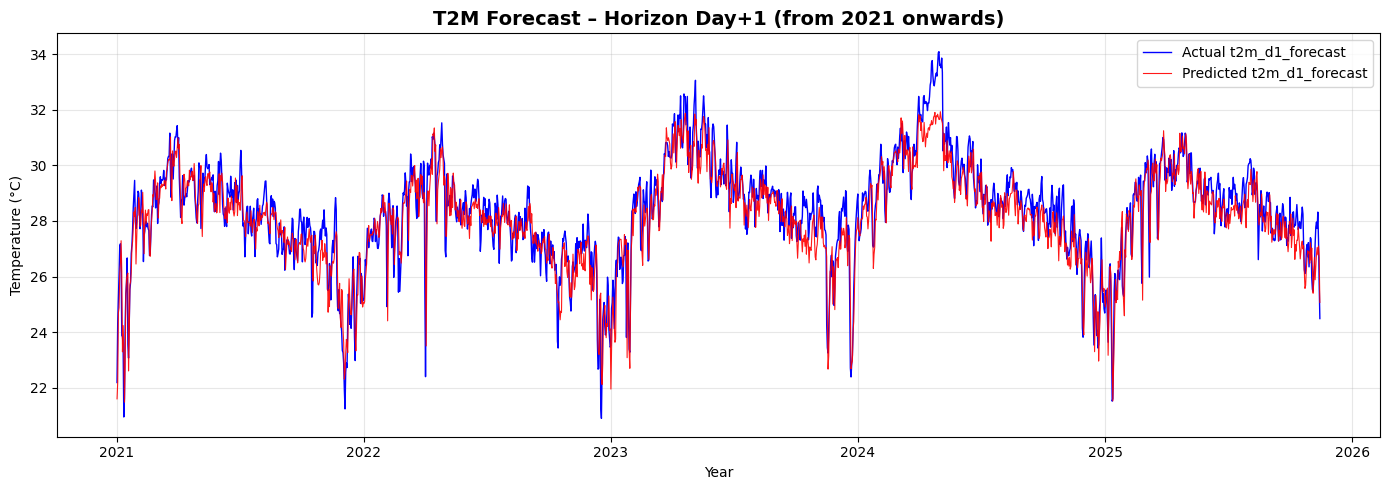

In [18]:

df["date"] = pd.to_datetime(df["date"])

dates_test = df["date"].iloc[train_size:].reset_index(drop=True)

mask_2021 = dates_test >= pd.to_datetime("2021-01-01")

dates_test_2021 = dates_test[mask_2021].reset_index(drop=True)
Y_test_2021 = Y_test.iloc[mask_2021.values].reset_index(drop=True)
Y_pred_test_2021 = pd.DataFrame(Y_pred_test[mask_2021.values]).reset_index(drop=True)

h = 0   # 0 = day+1, 6 = day+7
target_name = target_cols[h]

plt.figure(figsize=(14, 5))
plt.plot(dates_test_2021, Y_test_2021.iloc[:, h],
         label=f"Actual {target_name}",
         linewidth=1.0, color="blue")
plt.plot(dates_test_2021, Y_pred_test_2021.iloc[:, h],
         label=f"Predicted {target_name}",
         linewidth=0.8, color="red", alpha=0.9)

plt.title(f"T2M Forecast – Horizon Day+{h+1} (from 2021 onwards)", fontsize=14, fontweight="bold")
plt.xlabel("Year")
plt.ylabel("Temperature (°C)")
plt.legend()
plt.grid(True, alpha=0.3)

# ปรับการแสดงวันที่เป็นรายปี
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.YearLocator())       
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y")) 
plt.xticks(rotation=0)

plt.tight_layout()
plt.show()


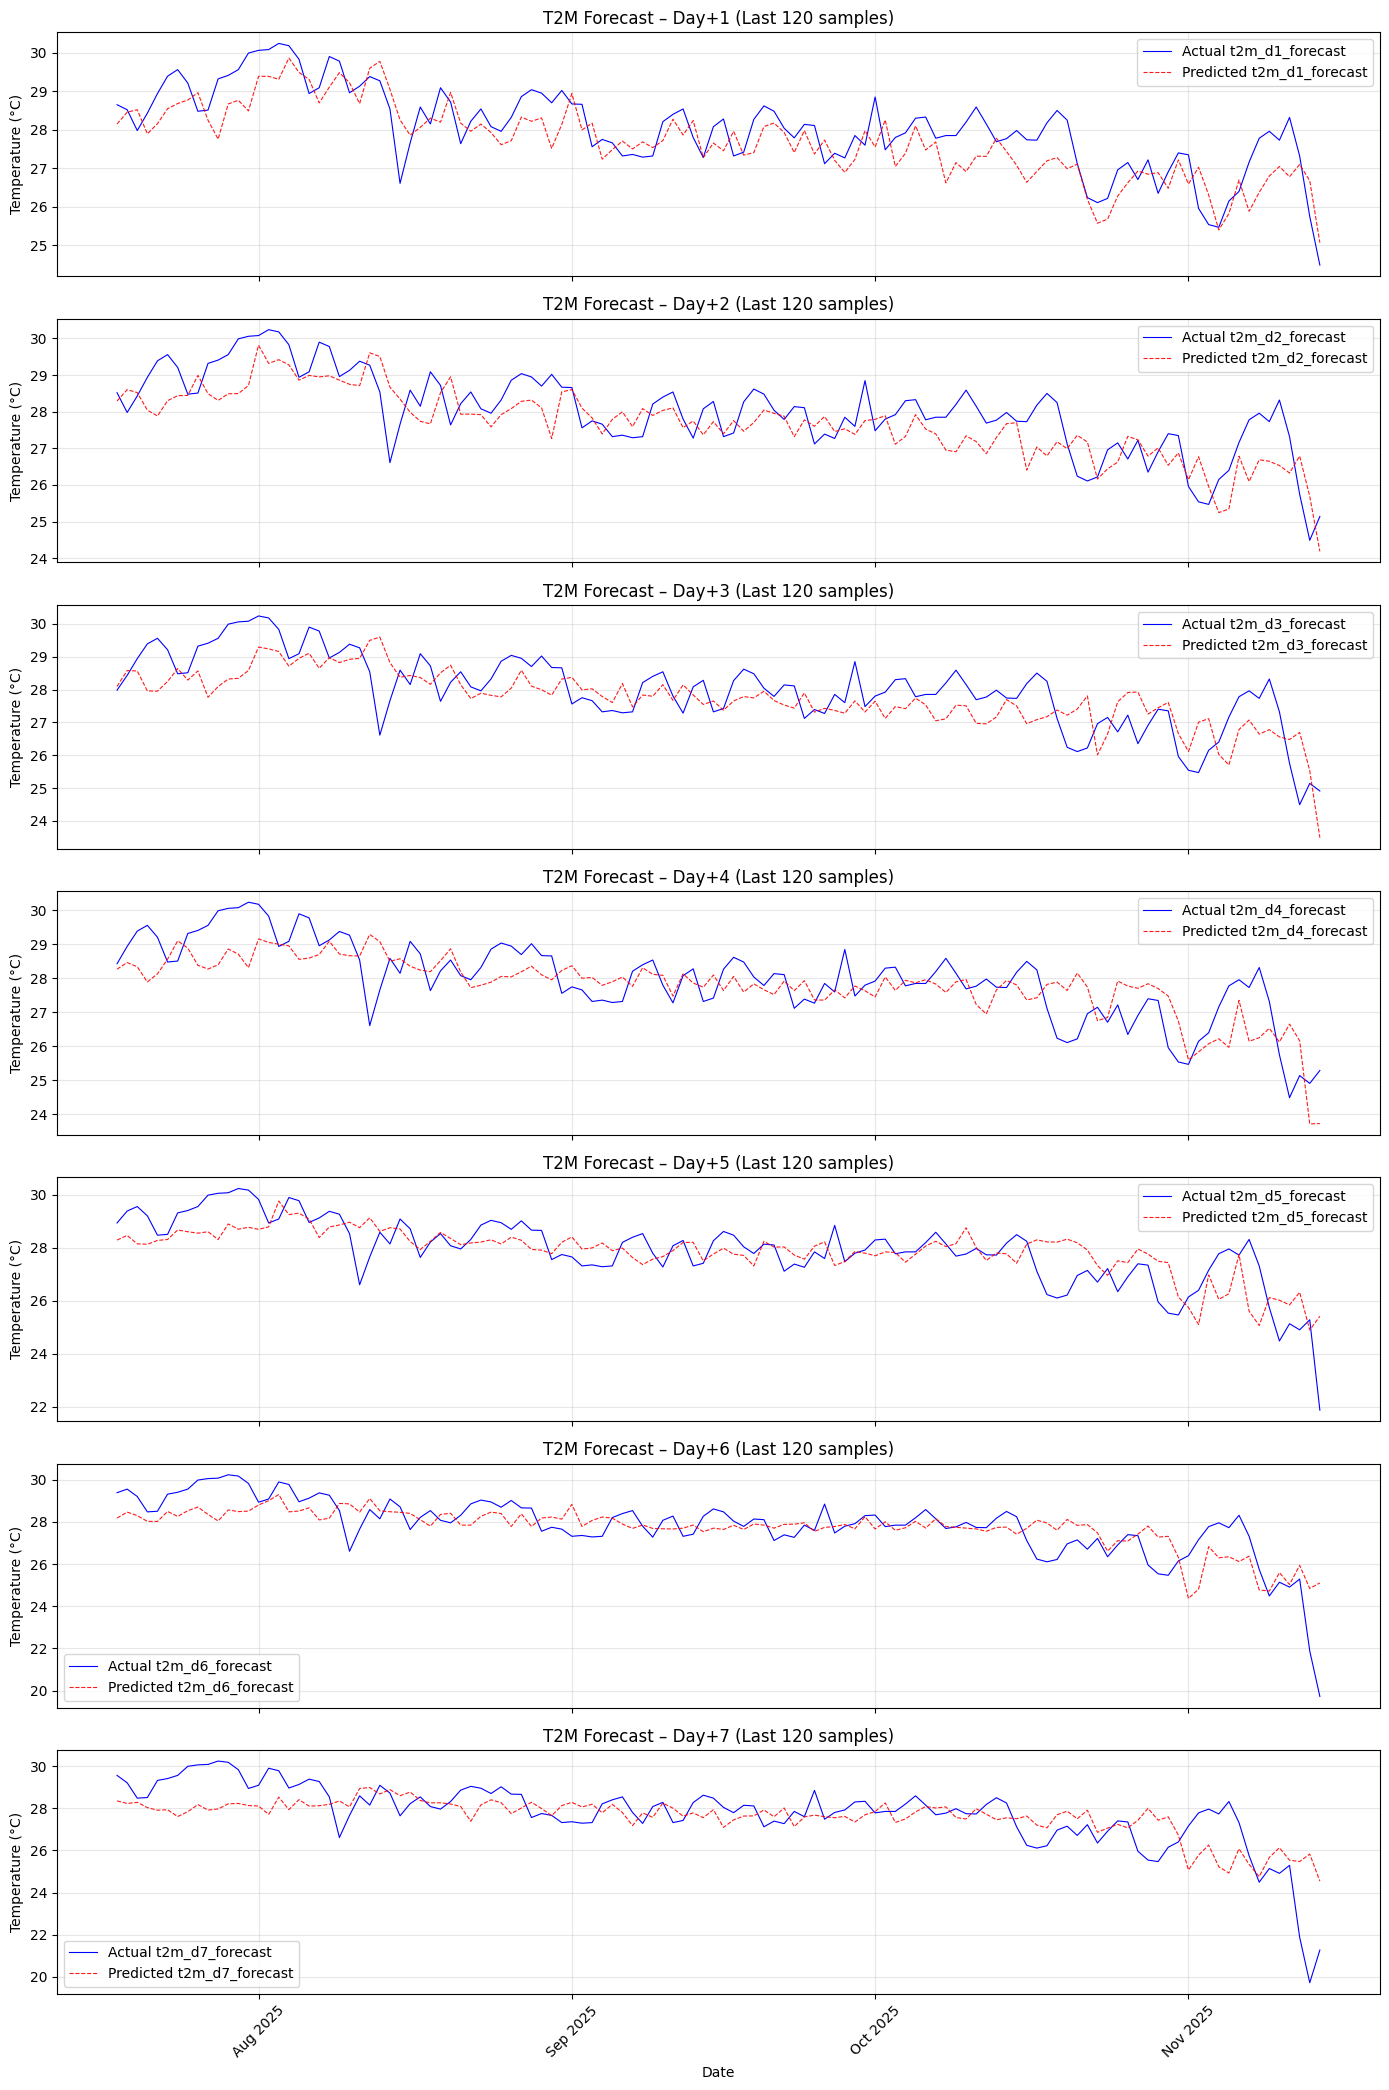

In [22]:

N = 120  
days = [f"Day+{i+1}" for i in range(LOOKAHEAD)]  

fig, axs = plt.subplots(LOOKAHEAD, 1, figsize=(14, 3*LOOKAHEAD), sharex=True)

for h in range(LOOKAHEAD):
    dates_zoom = dates_test[-N:]
    y_test_zoom = Y_test.iloc[-N:, h]
    y_pred_zoom = Y_pred_test[-N:, h]   
    
    axs[h].plot(dates_zoom, y_test_zoom,
                label=f"Actual {target_cols[h]}",
                 markersize=3, linewidth=0.8, color="blue")
    axs[h].plot(dates_zoom, y_pred_zoom,
                label=f"Predicted {target_cols[h]}",
                 markersize=3, linewidth=0.8, linestyle="--", color="red", alpha=0.9)
    
    axs[h].set_title(f"T2M Forecast – {days[h]} (Last {N} samples)")
    axs[h].set_ylabel("Temperature (°C)")
    axs[h].legend()
    axs[h].grid(True, alpha=0.3)

# ปรับแกน X ให้แสดงรายเดือน
ax = axs[-1]
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))   
ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %Y"))  
plt.xticks(rotation=45)

plt.xlabel("Date")
plt.tight_layout()
plt.show()
